In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import keras
import tensorflow as tf
import joblib

## For reproducibility

In [2]:
tf.random.set_seed(1)

In [3]:
data = requests.get("").json()

In [4]:
df = pd.DataFrame.from_dict(data['raw_data'])

In [5]:
def create_dataset(data, steps):
  features, labels = [], []
  for i in range(len(data)-steps):
    data_seq = data[i: i+steps, :]
    features.append(data_seq)

    seq_label = data[i+steps, :]
    labels.append(seq_label)

  return np.array(features), np.array(labels)

In [6]:
df.head()

,timestep_time,vehicle_0_pos,vehicle_1_pos,vehicle_10_pos,vehicle_11_pos,vehicle_12_pos,vehicle_13_pos,vehicle_14_pos,vehicle_15_pos,vehicle_16_pos,vehicle_17_pos,vehicle_19_pos,vehicle_2_pos,vehicle_4_pos,vehicle_5_pos,vehicle_6_pos,vehicle_7_pos,vehicle_8_pos,vehicle_0_speed,vehicle_1_speed,vehicle_10_speed,vehicle_11_speed,vehicle_12_speed,vehicle_13_speed,vehicle_14_speed,vehicle_15_speed,vehicle_16_speed,vehicle_17_speed,vehicle_19_speed,vehicle_2_speed,vehicle_4_speed,vehicle_5_speed,vehicle_6_speed,vehicle_7_speed,vehicle_8_speed
0,54,643.23,362.75,476.04,551.59,441.71,113.18,383.10,167.00,203.39,104.06,200.55,186.78,99.19,55.45,30.70,18.04,5.10,12.13,6.92,9.78,13.06,11.07,3.06,12.14,4.94,6.72,3.66,10.55,11.54,6.16,6.93,4.33,5.77,0.00
1,55,655.90,370.55,486.83,564.90,452.88,116.03,395.42,171.63,211.02,108.27,211.44,199.25,103.51,61.61,36.01,24.82,6.55,12.66,7.80,10.79,13.31,11.16,2.85,12.32,4.62,7.63,4.21,10.88,12.47,4.32,6.16,5.32,6.78,1.45
2,56,668.23,378.11,497.09,578.71,464.19,119.14,406.73,177.03,218.35,111.52,222.21,211.16,107.05,67.78,40.62,32.47,9.50,12.33,7.56,10.26,13.82,11.31,3.11,11.31,5.40,7.33,3.25,10.77,11.91,3.54,6.17,4.61,7.65,2.94
3,57,679.96,385.32,507.35,591.86,475.16,122.11,419.15,181.79,225.11,115.34,232.95,223.58,110.50,75.01,45.28,39.39,15.02,11.73,7.21,10.26,13.15,10.97,2.98,12.42,4.76,6.76,3.82,10.75,12.41,3.44,7.24,4.65,6.92,5.52
4,58,692.82,393.16,517.24,604.84,486.88,124.68,431.39,186.27,231.74,118.68,243.81,235.65,113.74,81.46,49.98,46.90,22.57,12.86,7.84,9.88,12.98,11.72,2.57,12.24,4.48,6.63,3.34,10.86,12.07,3.24,6.45,4.71,7.51,7.55


In [7]:
df.drop(columns=['timestep_time'], inplace=True)

In [8]:
train_df = df.iloc[:1200, :]
test_df = df.iloc[1200:, :]

In [9]:
# scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

In [10]:
train_dff = scaler.transform(train_df)
test_dff = scaler.transform(test_df)

In [11]:
train_dff.shape, test_df.shape

((1200, 34), (271, 34))

In [12]:
TIME_STEPS = 2

train_features, train_labels = create_dataset(train_dff, TIME_STEPS)
test_features, test_labels = create_dataset(test_dff, TIME_STEPS)

Epoch 1/500
17/17 [==============================] - 5s 89ms/step - loss: 0.3574 - val_loss: 0.6181
Epoch 2/500
17/17 [==============================] - 0s 7ms/step - loss: 0.3084 - val_loss: 0.5375
Epoch 3/500
17/17 [==============================] - 0s 8ms/step - loss: 0.2624 - val_loss: 0.4628
Epoch 4/500
17/17 [==============================] - 0s 9ms/step - loss: 0.2194 - val_loss: 0.3950
Epoch 5/500
17/17 [==============================] - 0s 9ms/step - loss: 0.1815 - val_loss: 0.3366
Epoch 6/500
17/17 [==============================] - 0s 9ms/step - loss: 0.1494 - val_loss: 0.2868
Epoch 7/500
17/17 [==============================] - 0s 8ms/step - loss: 0.1238 - val_loss: 0.2459
Epoch 8/500
17/17 [==============================] - 0s 8ms/step - loss: 0.1035 - val_loss: 0.2127
Epoch 9/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0874 - val_loss: 0.1855
Epoch 10/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0750 - val_loss: 0.1632
Epoch 11

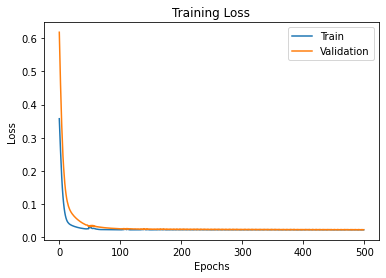

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(train_features.shape[1], train_features.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(5))
model.add(keras.layers.Dense(34))

model.compile(optimizer='adam', loss=['mse', 'mae'])

history = model.fit(train_features, train_labels, batch_size=64, epochs=500, shuffle=False, validation_split=0.1)

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [16]:
p = model.predict(test_features)

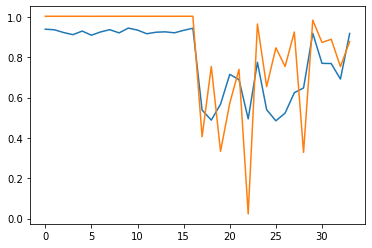

In [17]:
plt.plot(p[0])
plt.plot(test_labels[0])

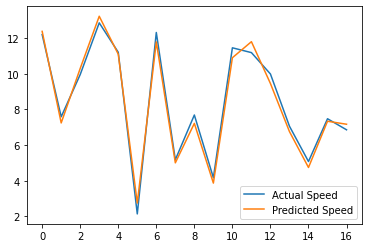

In [18]:
plt.plot(scaler.inverse_transform(test_labels)[0][17:], label="Actual Speed")
plt.plot(scaler.inverse_transform(p)[0][17:], label="Predicted Speed")
plt.legend()

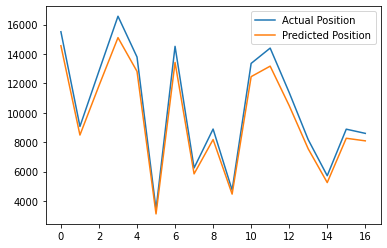

In [19]:
plt.plot(scaler.inverse_transform(test_labels)[0][:17], label="Actual Position")
plt.plot(scaler.inverse_transform(p)[0][:17], label="Predicted Position")
plt.legend()

In [20]:
test_labels

array([[1.00250011, 1.00256893, 1.00239952, ..., 0.88848921, 0.75330396,
        0.87723785],
       [1.00333461, 1.00333892, 1.0032807 , ..., 0.92805755, 0.92511013,
        0.84143223],
       [1.00417652, 1.00414689, 1.00411404, ..., 0.60791367, 0.57268722,
        0.91432225],
       ...,
       [1.22458752, 1.22443039, 1.22448402, ..., 0.99280576, 0.89427313,
        0.98721228],
       [1.22543213, 1.22523951, 1.22531169, ..., 0.67985612, 0.74008811,
        0.90920716],
       [1.2262282 , 1.2260728 , 1.22609559, ..., 0.96043165, 0.59911894,
        0.9168798 ]])

In [21]:
model.save('Min_Max_Scaled.h5')
joblib.dump(scaler, 'Min_Max_Scaler.gz')

['Min_Max_Scaler.gz']